# Music Recommendation System
## Notebook 02 : Building a Recommender

**Author**: Saad Abbas    
**Date**: 30 May 2019
______________________________________________________________________________________________________________________________

## Contents <a name="contents"></a>
- [1.0 Introduction](#introduction)
- [2.0 Data Loading and Preprocessing](#load)
- [3.0 Content-Based Filtering](#content)
- [4.0 Collaborative Recommendation](#collaborative)
    - [4.1 Initial evaluation of predictive models](#initial)
    - [4.2 Hyper-parameter tuning](#hyperparameter)
- [5.0 Making Recommendations](#recommendations)
    - [5.1 Recommendations for existing users](#existing)
    - [5.2 Recommendations for new users](#new)
- [6.0 Conclusion](#conclusion)

## 1.0 Introduction <a id='introduction'></a>
This project is based on the [KK-Box Music Recommendation Challenge](https://www.kaggle.com/c/kkbox-music-recommendation-challenge) hosted on Kaggle. I have split it into two notebooks (preliminary analysis and predictive modelling).

This notebook will focus on building a Recommendation System using the [Scikit-Surprise](http://surpriselib.com/) library.

The key deliverables of this notebook are as follows:
- Testing different algorithms for best performance
- Fine tune the selected model to improve accuray
- Create function for song recommendation using the trained model

For description and definitions of the dataset, please refer Notebook 01.

In [218]:
# general libraries
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm
from pathlib import Path
from itertools import product
import dill

# Libraries for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
sns.set_style('darkgrid')

# scikit-learn preprocessing and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

# scipy similarity functions
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine

# scikit-surprise algorithms
from surprise import Reader, Dataset, KNNBasic, SVD, BaselineOnly, \
                     SVDpp, NMF, CoClustering, Trainset, dump
from surprise.model_selection import train_test_split

## 2.0 Data Loading and Preprocessing<a id='load'></a>

The data I am using is a smaller subset of the Kaggle challenge dataset. Let us read in the csv files and have a sense of the items in our data.

In [179]:
datapath = Path('../datasets/')

data = pd.read_csv(datapath / 'train_small.csv')
songs = pd.read_csv(datapath / 'songs_small_modified.csv')

In [180]:
print('Count of user-item sets in data: {:,}'.format(data.shape[0]))
print('Count of unique users in data: {:,}'.format(data['msno'].nunique()))
print('Count of unique songs in data: {:,}'.format(data['song_id'].nunique()))

Count of user-item sets in data: 1,106,612
Count of unique users in data: 28,037
Count of unique songs in data: 141,032


In [181]:
print('Count of unique artists in songs: {:,}'.format(songs['artist_name'].nunique()))

Count of unique artists in songs: 21,118


There are some null values in the columns; however we will be using collaborative filtering for this project which is not going to take those columns into account, so there is no need to impute any values in there.

In [182]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141032 entries, 0 to 141031
Data columns (total 10 columns):
song_id              141032 non-null object
song_length          141019 non-null float64
genre_ids            141032 non-null object
artist_name          141019 non-null object
composer             141032 non-null object
lyricist             141032 non-null object
language             118634 non-null object
name                 141032 non-null object
isrc                 141032 non-null object
song_length_group    141032 non-null object
dtypes: float64(1), object(9)
memory usage: 10.8+ MB


Some the columns in the songs dataframe are important for our first step (building a simple recommender using song metadata similarity). I will impute some of these values in the below code.

In [183]:
# Fill null values for song dataset
songs['song_length'] = songs['song_length'].fillna(songs['song_length'].mean())
songs['name'] = songs['name'].fillna('-not_available-')
songs['artist_name'] = songs['artist_name'].fillna('-not_available-')
songs['language'] = songs['language'].fillna(songs['language'].mode()[0])
for col in ['genre_ids', 'composer', 'lyricist']:
    songs[col] = songs[col].fillna(' ')

# Drop irrelevant columns
songs = songs.drop(['isrc'], axis=1).reset_index(drop=True)

In order to make the code easier to run and debug, I will change all the user and song ID values to integers.

In [184]:
# Change the user and song id to integers
new_users = pd.DataFrame({'msno': data['msno'].unique(), 
                          'new_msno': [i for i in range(1, data['msno'].nunique()+1)]})
songs['new_song_id'] = [i for i in range(1, songs['song_id'].nunique()+1)]

data = data.merge(new_users, how='left', on='msno')
data = data.merge(songs, how='left', on='song_id')

data = data[['new_msno', 'new_song_id', 'target']]
data.columns = ['msno', 'song_id', 'target']

songs = songs[['new_song_id', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 'name']]
songs.columns = ['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 'name']
data['msno'].nunique(), data['song_id'].nunique(), songs['song_id'].nunique()

(28037, 141032, 141032)

## 3.0 Content-Based Filtering <a name="content"></a>

One of the simplest methods of making a media recommender is to recommend items that have similar features to the ones a user already likes or has rated highly. This is done using the metadata available for the song or media. In our case, the features of songs available are as follows:
- Song Name
- Artist Name
- Lyricist Name
- Composer Name
- Genre
- Song Length
- Language

The song name, artist name, lyricist and composer are quite unique to each song, and will not give beneficial results when checking for song similarity. The useful features we can utilize are the genre's, song lengths and language.

For the genre's, I am going to vectorize them using Tf-Idf vectoriser to create a vector space of features. I will append this with song length and language, to get a matrix of song metadata.

In [185]:
# Column vectorizer function
def vectorize(column):
    splitted = column.map(lambda x: ' '.join([each for each in x.replace('|',' ').split()]))
    tfidf = TfidfVectorizer().fit(splitted)
    vector_df = pd.DataFrame(tfidf.transform(splitted).todense(), columns=tfidf.get_feature_names())
    return vector_df

In [186]:
# Convert genre_ids to spaced text and vectorize
genre_vec = vectorize(songs['genre_ids'])

In [189]:
# Combine genre vector to song_lenth and language
song_metadata = pd.concat([genre_vec, 
                           pd.DataFrame(MinMaxScaler().fit_transform(songs[['song_length']]), 
                                        columns=['song_length'])], axis=1)

song_metadata.head()

,1007,1011,1019,102,1026,1033,1040,1047,1054,1068,...,947,95,958,965,972,979,986,993,na,song_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018052
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021242
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025111
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012773
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021589


Now that the song metadata matrix is ready, I will create a function which uses cosine similarity to give back the 20 top matching songs provided a song the user has liked. This is not an ideal recommendation engine, however it is a useful tool in order to recommend media to a new user where user preference history is not available.

In [190]:
# Function to return 20 top matching songs based on genre, song length and language
def top_matching(song_index, filter_by_lang='yes'):
    # Print text with song searched for
    print('Searching for top twenty songs matching {} by {} at index {}...'.format(songs.loc[song_index, 'name'], 
                                                                    songs.loc[song_index, 'artist_name'], song_index))
    similarities = []
    print('-'*90)
    
    # Check if language should be used as a filter
    if filter_by_lang=='yes':
        songs_subset = songs[songs['language']==songs.loc[song_index, 'language']]
    elif filter_by_lang=='no':
        songs_subset = songs
    else:
        print("ERROR!!")
        print("Wrong input in 'filter_by_lang', only 'yes' or 'no' accepted")
        return
    
    # Loop through indexes and compute cosine similarity
    for i in songs_subset.index:
        if i!=song_index:
            simil = 1 - cosine(song_metadata.loc[song_index], song_metadata.loc[i])
            similarities.append((i, simil))
    
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:20]
    
    # Print top 20 matching songs found
    for index, match in similarities:
        print('Index {}: {} by {} (matching {:.5f}%)'.format(index, songs.loc[index, 'name'], 
                                                             songs.loc[index, 'artist_name'], match*100))

Time to test our function. I am going to search for songs matching the following:
- Metallica: The Unforgiven (rock music)
- Eminem: Square Dance (hip-hop / rap)

In [191]:
top_matching(33077) # Check for matching songs to Metallica

Searching for top twenty songs matching The Unforgiven by Metallica at index 33077...
------------------------------------------------------------------------------------------
Index 73646: Nothing Else Matters by Metallica (matching 100.00000%)
Index 21453: Light by Talvin Singh (matching 99.99999%)
Index 69305: The Unforgiven II by Metallica (matching 99.99996%)
Index 90501: Rocket Queen by Guns N' Roses (matching 99.99994%)
Index 114328: Paradise City by Guns N' Roses (matching 99.99983%)
Index 60211: I Still Love You by Kiss (matching 99.99979%)
Index 10792: Paradise City by Guns N' Roses (matching 99.99979%)
Index 30756: Layla by Eric Clapton (matching 99.99962%)
Index 6185: Patience by Guns N' Roses (matching 99.99960%)
Index 63045: Sweet Child O' Mine by Guns N' Roses (matching 99.99960%)
Index 100682: Sweet Child O' Mine by Guns N' Roses (matching 99.99958%)
Index 112121: Don't Know What You Got (Till It's Gone) by Cinderella (matching 99.99957%)
Index 42893: (It's Hard) Lettin

In [192]:
top_matching(23790) # Check for matching songs to Eminem

Searching for top twenty songs matching Square Dance by Eminem at index 23790...
------------------------------------------------------------------------------------------
Index 71600: I Know What You Want by Busta Rhymes (matching 100.00000%)
Index 16085: Hope (feat. Ty Dolla $ign) by Wiz Khalifa (matching 100.00000%)
Index 61629: Ruckus In B Minor by Wu-Tang Clan (matching 100.00000%)
Index 67991: YNO by Rae Sremmurd (matching 100.00000%)
Index 43731: My Humps by Interscope Presents: Club Bangers (matching 100.00000%)
Index 40293: Pistol Pistol by D-12 (matching 100.00000%)
Index 52660: Put On(Young Jeezy feat. Kanye West) by Hip Hop (matching 100.00000%)
Index 73795: The Donald by A Tribe Called Quest (matching 100.00000%)
Index 76371: So Bad by Eminem (matching 100.00000%)
Index 106528: From Time by Drake (matching 100.00000%)
Index 101911: Tuesday (feat. Drake) by I LOVE MAKONNEN (matching 100.00000%)
Index 98950: Do You Really (Thang Thang) by Wu-Tang Clan (matching 100.00000%)
I

Many top songs are showing near 100% match. This is because the only notable feature being compared is the genre, and the dataset has very similar genres for many songs. If there was more granular data available, or some more metadata we would be getting better results; however for the purpose of this project we have built an item-based predictor.

Let us move on and build a recommendation using predictive modelling.

## 4.0 Collaborative Recommendation <a name="collaborative"></a>
The theory behind collaborative filtering is that any two persons may have similar tastes in music due to some 'latent' features. The collaborative models uses the user's likes and preferences to find users with matching tastes, and the items liked by one user is recommended to a user with similar taste who has not tried that item.

Collaborative recommendations in productions are multi-layered and quite complex, often tailored to the specific business and designed for hyper-personalization towards the user. In this project, I will create a relatively simple recommendation model using the Scikit-Surprise library which have built-in recommendation functions.

The first step, as always, is to split our data into train and test sets for training and validation.

Scikit-surprise uses special object types called Datasets, Trainsets and Testsets for it's models (Pandas dataframes do not work). Below I am converting my pandas dataframes into Datasets. The functions requires an input of the range of rating values. Since our problem only has a target of 0 and 1, I will use 0 and 1 as my rating scale.

In [14]:
# Scikit-Surprise Trainset
dataset = Dataset.load_from_df(data[['msno', 'song_id', 'target']], Reader(rating_scale=(0,1)))
trainset, testset = train_test_split(dataset, test_size=0.25, shuffle=True, random_state=36)

Another limitation with Surprise is that it treats the ratings as a continuous variable (which in real life it usually is). The default method of Surprise to evaluate models is to calculate RMSE values.

Our dataset in this project has a binary classification target, so RMSE will not work. I need to calculate the accuracy scores, precision / recall and ROC-AUC to check my model's accuracies. To work around this, I will convert the Surprise trainset and testset to a pandas dataframe and run the scikit-learn accuracy functions on the model predictions to evaluate performance.

In [15]:
# Define function to convert Surprise testset to Pandas dataframe
def convert_to_df(testlist):
    users = []
    items = []
    ratings = []
    for user, item, rating in testlist:
        users.append(user)
        items.append(item)
        ratings.append(rating)
    
    ratings = [0 if x==1.0 else 1 for x in ratings]
    df = pd.DataFrame({'msno': users, 'song_id': items, 'target': ratings})
    return df

In [16]:
training_df = convert_to_df(trainset.build_testset())
testing_df = convert_to_df(testset)

In [17]:
training_df.shape, testing_df.shape

((829959, 3), (276653, 3))

Scikit-surprise does not have the functionality to give a 'predict all' on a test set similar to sklearn. The format of Scikit-Surprise is that it takes in a userId and itemId as an input, and the model will output a predicted rating for that item. Below, I will create a function to loop through all user and item Id's and give a list output of predictions.

In [293]:
# Define Function to give predictions as a list
def predictions(model, df):
    predictions = []
    for row in df[['msno','song_id']].itertuples():
        predictions.append(model.predict(uid=row.msno, iid=row.song_id).est)
    return predictions

### 4.1 Initial evaluation of predictive models <a name="initial"></a>
As in any project, I will run multiple models on the training data and test out on my testing data using the default algorithm settings. I am going to use the output evaluations to finalize which model to use for my data.

In [19]:
# Define function to train and evaluate models
def train_models(estimator_list, estimator_names, trainset, training_df, testing_df):
    if len(estimator_list)==len(estimator_names):
        trained_models = []
        times_taken = []
        train_accuracy_values = []
        test_accuracy_values = []
        predictions_list = []
        print('Received {} estimator(s)'.format(len(estimator_names)))
        print('')
        for i, estimator in enumerate(estimator_list):
            print('Training', estimator_names[i], '...')
            try:
                # Train and test model
                t_0 = time()
                model = estimator
                model.fit(trainset)                 
                # Predictions and accuracies
                train_preds = predictions(model, training_df)
                test_preds = predictions(model, testing_df)
                train_preds = [0 if i<0.5 else 1 for i in train_preds]
                test_preds = [0 if i<0.5 else 1 for i in test_preds]
                train_accuracy = accuracy_score(training_df['target'], train_preds)
                test_accuracy = accuracy_score(testing_df['target'], test_preds)

                # Append all results
                trained_models.append(model)        
                train_accuracy_values.append(train_accuracy)
                test_accuracy_values.append(test_accuracy)
                times_taken.append(time() - t_0)    
                print('='*60)
     
            except:
                print('Training failed...')
                trained_models.append('na')
                train_accuracy_values.append(0)
                test_accuracy_values.append(0)
                times_taken.append(0)
                print('='*60)
        
        return trained_models, train_accuracy_values, test_accuracy_values, times_taken
    
    else:
        print('Length of estimators and names not matching!')
        return None

Let us run the above function using multiple algorithms and compare the results.

In [20]:
# Define estimator names and algorithms for evaluation
estimators = [BaselineOnly(), KNNBasic(), SVD(), SVDpp(), NMF(), CoClustering()]
estimator_names = ['BaselineOnly', 'KNNBasic','SVD', 'SVDpp', 'NMF', 'CoClustering']

# Evaluate the models
models, train_values, test_values, times = train_models(estimators, estimator_names, trainset, training_df, testing_df)

Received 6 estimator(s)

Training BaselineOnly ...
Estimating biases using als...
Training KNNBasic ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Training SVD ...
Training SVDpp ...
Training NMF ...
Training CoClustering ...


In [21]:
model_performance = pd.DataFrame({'model': estimator_names, 'train_accuracy': train_values,
                                  'test_accuracy': test_values, 'time_to_train': times})
model_performance['train_test_difference'] = model_performance['train_accuracy'] - model_performance['test_accuracy']
model_performance

,model,train_accuracy,test_accuracy,time_to_train,train_test_difference
0,BaselineOnly,0.707611,0.652453,23.519683,0.055158
1,KNNBasic,0.954310,0.555118,594.874708,0.399192
2,SVD,0.814661,0.639465,155.751931,0.175195
3,SVDpp,0.754999,0.646246,2605.974874,0.108752
4,NMF,0.849912,0.616997,184.806916,0.232915
5,CoClustering,0.754284,0.615800,106.373446,0.138484


Based on the above performance values, I will go with SVD to see if I can improve on it.

### 4.2 Hyper-parameter tuning <a name="hyperparameter"></a>
I will try to loop through different hyper-parameter values for the above top performing models to find the best set of parameters for our final model.

In [22]:
# Define function to evaluate model performance 
def test_model_performance(algo, df, metric='accuracy', thresh=0.5):
    preds = predictions(algo, df)
    if metric=='accuracy':
        # Calculating accuracy    
        pred_labels = [0 if i<thresh else 1 for i in preds]
        result = accuracy_score(df['target'], pred_labels)
        return result
    elif metric=='auc':
        fpr, tpr, _ = roc_curve(df['target'], preds)
        result = auc(fpr, tpr)
        return (fpr, tpr, result)
    else:
        print('Error')

#### Tuning the SVD Model:

In [23]:
# Setting range of hyper-parameters
learning_rates = [0.005, 0.01, 0.015]
regularizations = [0.02, 0.03, 0.04]
latent_factors = [70, 90, 110]
lr_list = []
reg_list = []
n_list = []
svd_training_accuracies = []
svd_testing_accuracies = []

# Loop through individual set of hyperparameters, train, test and evaluate
for lr, reg, n in product(learning_rates, regularizations, latent_factors):
    lr_list.append(lr)
    reg_list.append(reg)
    n_list.append(n)
    algo = SVD(n_factors=n, reg_all=reg, lr_all=lr, random_state=9, biased=False).fit(trainset)
    svd_training_accuracies.append(test_model_performance(algo, training_df)*100)
    svd_testing_accuracies.append(test_model_performance(algo, testing_df)*100)

In [24]:
# Build performance DataFrame
svd_performance = pd.DataFrame({'learning_rate': lr_list,
                                'regularization':reg_list,
                                'latent_factors':n_list,
                                'train_accuracy': svd_training_accuracies,
                                'test_accuracy': svd_testing_accuracies})
svd_performance['difference'] = svd_performance['train_accuracy'] - svd_performance['test_accuracy']

In [25]:
svd_performance.sort_values('test_accuracy', ascending=False).head(5)

,learning_rate,regularization,latent_factors,train_accuracy,test_accuracy,difference
24,0.015,0.04,70,86.289082,60.749025,25.540057
15,0.010,0.04,70,78.812929,60.464553,18.348376
25,0.015,0.04,90,88.847521,60.352499,28.495022
21,0.015,0.03,70,89.290314,60.304786,28.985528
12,0.010,0.03,70,80.879296,60.118632,20.760664


The above dataframe provide accuracy scores over train and test for difference combinations of hyper-parameters. Below I will plot the different performance charts and check what effect each hyper-parameter has on the model.

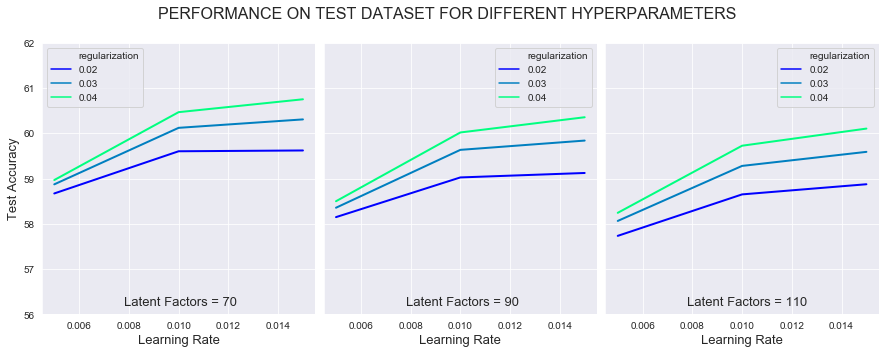

In [221]:
# Plot performance graphs
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
sns.lineplot(x='learning_rate', y='test_accuracy', hue='regularization', legend='full',
             data=svd_performance[svd_performance['latent_factors']==70], ax=ax[0], palette='winter', linewidth=2)
sns.lineplot(x='learning_rate', y='test_accuracy', hue='regularization', legend='full',
             data=svd_performance[svd_performance['latent_factors']==90], ax=ax[1], palette='winter', linewidth=2)
sns.lineplot(x='learning_rate', y='test_accuracy', hue='regularization', legend='full',
             data=svd_performance[svd_performance['latent_factors']==110], ax=ax[2], palette='winter', linewidth=2)
ax[0].set_ylim(56, 62)

ax[0].text(0.0078,56.2, 'Latent Factors = 70', fontsize=13)
ax[1].text(0.0078,56.2, 'Latent Factors = 90', fontsize=13)
ax[2].text(0.0078,56.2, 'Latent Factors = 110', fontsize=13)

ax[0].set_ylabel('Test Accuracy', fontsize=13)
ax[0].set_xlabel('Learning Rate', fontsize=13)
ax[1].set_xlabel('Learning Rate', fontsize=13)
ax[2].set_xlabel('Learning Rate', fontsize=13)

plt.suptitle('PERFORMANCE ON TEST DATASET FOR DIFFERENT HYPERPARAMETERS', fontsize=16)
plt.subplots_adjust(hspace=0.05, wspace=0.03)
plt.show()

The above graphs exhibit the following:
- Increasing the number of latent factors decreases test accuracies (as it tends to  overfit the model to training).
- Increases regularization increases test accuracy.
- Accuracy peaks at Learning Rate of 0.01 at 70 latent factors.

Below I will train my final model and plot the AUC-ROC curve.

In [27]:
svd = SVD(n_factors=70, lr_all=0.008, reg_all=0.1).fit(trainset)

In [28]:
training_fpr, training_tpr, training_auc = test_model_performance(svd, training_df, metric='auc', thresh=0.5)
testing_fpr, testing_tpr, testing_auc = test_model_performance(svd, testing_df, metric='auc', thresh=0.5)

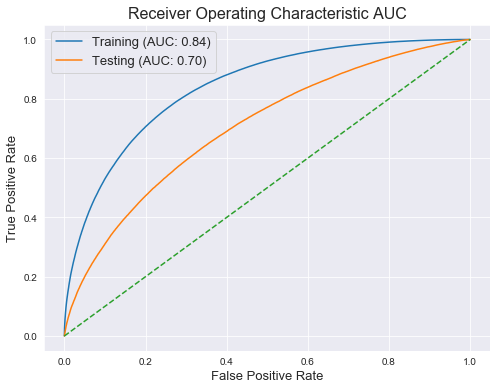

In [222]:
fig = plt.figure(figsize=(8,6))
plt.plot(training_fpr, training_tpr, label='Training (AUC: {:.2f})'.format(training_auc))
plt.plot(testing_fpr, testing_tpr, label='Testing (AUC: {:.2f})'.format(testing_auc))
plt.plot([0,1], [0,1], linestyle='--')
plt.legend(fontsize=13)
plt.title('Receiver Operating Characteristic AUC', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.show()

In [ ]:
# Function to normalize confusion matrix
def normalizer(df):
    df[2] = df[0] + df[1]
    df[0] = df[0] / df[2]
    df[1] = df[1] / df[2]
    return df.drop(2, axis=1)

In [30]:
# Confusion matrices for test set at different thresholds
pred_prob = predictions(svd, testing_df)

In [31]:
# Create data for threshold plot
thresh_list = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]
true_postivies = []
false_positives = []
true_negatives = []
false_negatives = []
counts = [i for i in range(1, 10)]

for thresh in thresh_list:
    preds = [0 if x<thresh else 1 for x in pred_prob]
    tn, fp, fn, tp = confusion_matrix(testing_df['target'], preds).ravel()
    true_postivies.append(tp)
    false_positives.append(fp)
    true_negatives.append(tn)
    false_negatives.append(fn)
    
# Create data for Confusion Matrix
    # Theshold 0.5
labels_at_50 = [0 if x<0.5 else 1 for x in pred_prob]
confusion_50 = normalizer(pd.DataFrame(confusion_matrix(testing_df['target'], labels_at_50)))
    # Theshold 0.43
labels_at_43 = [0 if x<0.43 else 1 for x in pred_prob]
confusion_43 = normalizer(pd.DataFrame(confusion_matrix(testing_df['target'], labels_at_43)))
    # Theshold 0.3
labels_at_30 = [0 if x<0.3 else 1 for x in pred_prob]
confusion_30 = normalizer(pd.DataFrame(confusion_matrix(testing_df['target'], labels_at_30)))

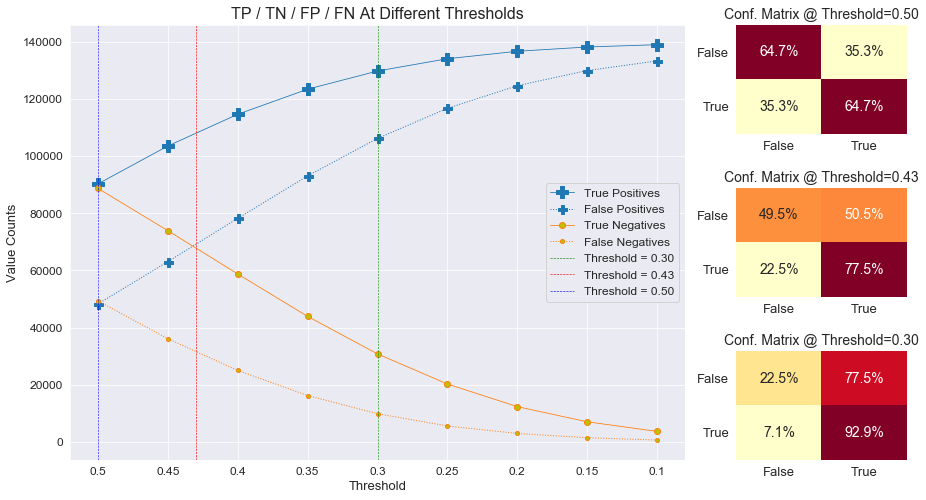

In [32]:
fig = plt.figure(1, figsize=(15,8))
gridspec.GridSpec(3,4)

# Large subplot
plt.subplot2grid((3,4), (0,0), colspan=3, rowspan=3)
plt.plot(counts, true_postivies, label='True Positives', color='C0', marker='P', 
         linewidth=0.8, markersize=12)
plt.plot(counts, false_positives, label='False Positives', color='C0', marker='P', 
         ls=':', linewidth=1, markersize=9)
plt.plot(counts, true_negatives, label='True Negatives', color='C1', marker='o', 
         linewidth=0.8, markersize=6, markerfacecolor='y')
plt.plot(counts, false_negatives, label='False Negatives', color='C1', marker='o', 
         ls=':', linewidth=1, markersize=4, markerfacecolor='y')
plt.xticks(counts, thresh_list, fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=5, color='g', linestyle='--', linewidth=0.6, label='Threshold = 0.30')
plt.axvline(x=2.4, color='r', linestyle='--', linewidth=0.6, label='Threshold = 0.43')
plt.axvline(x=1, color='b', linestyle='--', linewidth=0.6, label='Threshold = 0.50')
plt.xlabel('Threshold', fontsize=13)
plt.ylabel('Value Counts', fontsize=13)
plt.legend(fontsize=12)
plt.title('TP / TN / FP / FN At Different Thresholds', fontsize=16)

# Small subplot 1
plt.subplot2grid((3,4), (0,3))
sns.heatmap(confusion_50, annot=True, cbar=False, fmt='.1%', cmap='YlOrRd', annot_kws={'size':14})
plt.xticks([0.5,1.5], ['False', 'True'], fontsize=13)
plt.yticks([0.5,1.5], ['False', 'True'], fontsize=13, rotation=0)
plt.title('Conf. Matrix @ Threshold=0.50', fontsize=14)
    
# Small subplot 2
plt.subplot2grid((3,4), (1,3))
sns.heatmap(confusion_43, annot=True, cbar=False, fmt='.1%', cmap='YlOrRd', annot_kws={'size':14})
plt.xticks([0.5,1.5], ['False', 'True'], fontsize=13)
plt.yticks([0.5,1.5], ['False', 'True'], fontsize=13, rotation=0)
plt.title('Conf. Matrix @ Threshold=0.43', fontsize=14)

# Small subplot 3
plt.subplot2grid((3,4), (2,3))
sns.heatmap(confusion_30, annot=True, cbar=False, fmt='.1%', cmap='YlOrRd', annot_kws={'size':14})
plt.xticks([0.5,1.5], ['False', 'True'], fontsize=13)
plt.yticks([0.5,1.5], ['False', 'True'], fontsize=13, rotation=0)
plt.title('Conf. Matrix @ Threshold=0.30', fontsize=14)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

The threshold of 0.5 for prediction probability gives us a relatively good balance of true negatives and true positives with their false counterparts; however, for a recommendation I would prefer to have a higher true positive count (so as to have more predicted recommended items) at the expense of reducing my true negatives, which to me are not very critical for this case. 

I can do this by reducing my theshold to increase percentage of true positives. However, too low a threshold can result in all songs being predicted as recommended, which would practically mean not having predicted anything in the first place. A good place would be around 0.43 which gives a high count of true positives, and an approximate 50-50 balance of true and false negatives.

## 5.0 Making Recommendations <a name="recommendations"></a>
Now that the model is ready, I can define some functions which will give users some recommendations. I will tackle this in two separate parts:
- Recommendations for existing users
- Recommendations for new users

### 5.1 Recommendations for existing users <a name="existing"></a>
The trained model can be used to give predicted probability of a certain user liking a certain song. We can check the recommended songs by two methods:
1. Looping through the songs database to get the predicted probabilities of songs the user hasn't heard, and output the top few songs with highest probabilities.
2. Use the metadata of the songs liked by the user, and output the songs best matching those attributes.

Actual music recommendation engines use a combination of the two (not to mention more complicated algorithms including neural networks). I have already demonstrated the second method in a previous section; below I will define a function which will recommend 20 songs to an existing user. 

In [292]:
def recommend_to_existing_user(user_id):
    if user_id>=1 or user_id<=28037:
        # List of songs not heard by user
        songs_not_heard = data[data['msno']!=user_id]['song_id'].unique()
        predictions_dict = {'song_id': [], 'song_name':[], 'artist': [], 'language': [], 'like_probability(%)': []} #
        df_testset = [(user_id, song_id, 1.5) for song_id in songs_not_heard]
        test_result = svd.test(df_testset)
        result_sorted = sorted(test_result, key=lambda x: x[3], reverse=True)
        
        for result in result_sorted[:20]:    
            predictions_dict['song_id'].append(result[1])
            predictions_dict['song_name'].append(songs.loc[songs['song_id']==result[1]]['name'].values[0])
            predictions_dict['artist'].append(songs.loc[songs['song_id']==result[1]]['artist_name'].values[0])
            predictions_dict['language'].append(songs.loc[songs['song_id']==result[1]]['language'].values[0])
            predictions_dict['like_probability(%)'].append(round(result[3]*100,2))
        
        # Sort and filter first 20
        return pd.DataFrame(predictions_dict).sort_values('like_probability(%)', ascending=False)

Let's try to check the functionality of our collaborative recommendation engine. Below I will print out the 20 liked songs by a user:

In [275]:
train_language = pd.merge(data, songs, on='song_id', how='left')
train_language[train_language['msno']==577][['song_id','name','artist_name','language']].head(20)

,song_id,name,artist_name,language
588,130541,We’ll never know,韋禮安 (William Wei),Chinese
1438,12535,風箏,2012高中原創畢業歌合輯,Chinese
2257,62982,被遺忘的時光 (Forgotten time),蕭敬騰 (Jam Hsiao),Chinese
2527,96537,Heathens (Workout Mix) [128 BPM],Workout Remix Factory,English
5131,125449,Levels,Nick Jonas,English
5940,46342,I NEED U,BANGTAN BOYS,Korean
9655,118864,The Whisperer (feat. Sia),David Guetta,English
10365,75414,Lost Away,Sigma,English
14216,56299,Roses,The Chainsmokers feat. ROZES,English
15895,73362,Innocence,Flume,English


Below are the 20 recommendations for the same user:

In [272]:
recommend_to_existing_user(577)

,song_id,song_name,artist,language,like_probability(%)
0,27305,相安無事,周柏豪 (Pakho Chau),Chinese-3,100.00
1,10052,天灰,S.H.E,Chinese,98.54
2,6328,CANDY CANDY,Kyary Pamyu Pamyu (きゃりーぱみゅぱみゅ),Japanese,98.37
3,3065,Once I Had A Laugh,Norah Jones,English,96.47
4,37213,Sonnakimikonnaboku,Thinking Dogs,Japanese,95.65
5,24783,Season Song,証聲音樂圖書館 ECHO MUSIC,Korean,94.67
6,7886,Missing,Ayumi Hamasaki (浜崎あゆみ),Japanese,93.79
7,3529,Pure Happiness,吳昊恩+The Daniel Ho Trio,English,93.79
8,45358,愛唷,楊丞琳 (Rainie Yang),Chinese,93.75
9,3018,3% [Solji Solo],EXID,Korean,93.42


It is quite difficult to judge whether the recommendation is correct or not, there is not automatic way to do so. Trying to gauge similarity with the user's previous liked songs is not a good evaluation method, since collaborative algorithms work on user similarities and not item similarities.

The best recommenders use a hybrid of collaborative and content based approaches to provide hyper-personalized recommendations to users. A single company (e.g. Spotify) may use multiple trained models and algorithms across different clusters of users, based on what works best.

### 5.2 Recommendations for new users<a name="new"></a>
Having new users whose preference and historical information is not known is known as a **cold start problem**. There are a few ways of dealing with this, however the simplest is to have the new user search a few songs or artist he/she likes, and make recommendations based on item metadata for songs matching the ones the new user has selected. This is the same algorithm for [content-based recommendation](#content) demonstrated above.

## 6.0 Conclusion <a name="conclusion"></a>
The model is ready for making recommendations. After this, I will make a Flask application using this model to have a browser interface where users can see their recommendations.

In the industry, recommendation engines are far more complex and use multiple layers for prediction. Also, the models are trained and re-trained on new data continuously to keep the recommendations updated. There may be different trained models for geographic locations, age groups or even genders, as is best suited for the business.

This project was a exercise to go over the basics on building a recommendation model, however having more (and cleaner) data and clear business directions the recommendations can be further improved and refined.

I will serialize the model that I have finalized, to be used in the Flask application.

In [206]:
dump.dump('./SVD_model_dump.pkl', algo=svd)